In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from pymatgen.core import Composition, Element
import pickle as pkl
from matminer.featurizers.base import MultipleFeaturizer
from matminer.featurizers import composition as cf
from matminer.featurizers.conversions import StrToComposition
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import shap
from xgboost import XGBRegressor

In [2]:
with open('/home/jupyter/CJK/TempTime/data/ss_extracted_NO_IMPUTATION_precs_all_targets.pkl', 'rb') as f:
    papers = pkl.load(f)

In [3]:
# only use papers with sinter temps
papers = [x for x in papers if not np.isnan(x['temp_time_vector'][1])]

In [4]:
test_targets = [x['target'] for x in papers]
test_precs = [x['precursors'] for x in papers]
test_temps = [x['temp_time_vector'][1] for x in papers]

In [5]:
# get means
test_results = []
for target, precs, temps in zip(test_targets, test_precs, test_temps):
    if len(test_precs) == 0:
        continue
    found = False
    for result in test_results:
        if result["Target"] == target: # and set(result["Precursors"]) == set(precs):
            result["ss_sinter_temps"].append(temps)
            result["Precursors"].append(precs)
            found = True
    if not found:
        new_result = {}
        new_result["Target"] = target
        new_result["Precursors"] = [precs]
        new_result["ss_sinter_temps"] = []
        new_result["ss_sinter_temps"].append(temps)
        test_results.append(new_result)

In [6]:
target_names = [x["Target"] for x in test_results]
precursors = [x["Precursors"] for x in test_results]
temps = [np.mean(x["ss_sinter_temps"]) for x in test_results]
num_pts = [len(x["ss_sinter_temps"]) for x in test_results]

In [7]:
# feature_calculators = MultipleFeaturizer([
#     cf.Stoichiometry(),
#     cf.ElementProperty.from_preset("magpie"),
#     cf.ValenceOrbital(props=["avg"]),
#     cf.IonProperty(fast=True)
# ])
feature_calculators = MultipleFeaturizer([
    cf.ElementFraction()
])

In [8]:
feature_labels = feature_calculators.feature_labels()

In [9]:
data = pd.DataFrame()
data["targets"] = target_names
data["precursors"] = precursors
data["temperatures"] = temps
df = StrToComposition(target_col_id="composition_obj").featurize_dataframe(data, "targets", ignore_errors=True)
df = feature_calculators.featurize_dataframe(df, col_id="composition_obj", ignore_errors = True)

In [10]:
df

,targets,precursors,temperatures,composition_obj,H,He,Li,Be,B,C,...,Pu,Am,Cm,Bk,Cf,Es,Fm,Md,No,Lr
0,Sr0.5Nd0.5CoO3,"[[Co3O4, Nd2O3, SrCO3]]",1200.000000,"(Sr, Nd, Co, O)",0.0,0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0,0,0,0,0,0,0,0
1,NdCoO3,"[[Co3O4, Nd2O3], [Co2O3, Nd2O3], [Co2O3, Nd2O3]]",1200.000000,"(Nd, Co, O)",0.0,0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0,0,0,0,0,0,0,0
2,Sr0.4Pr0.6CoO3,"[[Co2O3, Pr6O11, SrCO3], [Co3O4, Pr6O11, SrCO3...",1250.000000,"(Sr, Pr, Co, O)",0.0,0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0,0,0,0,0,0,0,0
3,Sr0.4Gd0.6CoO3,"[[Co2O3, Gd2O3, SrCO3], [Co3O4, Gd2O3, SrCO3],...",1283.333333,"(Sr, Gd, Co, O)",0.0,0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0,0,0,0,0,0,0,0
4,Li1.3Mn0.65Ni0.35O2.3,"[[LiHO, MnO2, Ni(NO3)2], [LiHO, MnO2, Ni(NO3)2]]",800.000000,"(Li, Mn, Ni, O)",0.0,0,0.282609,0.0,0.0,0.0,...,0.0,0.0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11675,Sm0.05Ce0.95O2,"[[CeO2, Sm2O3]]",1690.000000,"(Sm, Ce, O)",0.0,0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0,0,0,0,0,0,0,0
11676,Sm0.55Ce0.45O2,"[[CeO2, Sm2O3]]",1690.000000,"(Sm, Ce, O)",0.0,0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0,0,0,0,0,0,0,0
11677,ZrTa2ZnO8,"[[Ta2O5, ZnO, ZrO2]]",1360.000000,"(Zr, Ta, Zn, O)",0.0,0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0,0,0,0,0,0,0,0
11678,La2Y0.32Zr1.68O6.84,"[[La2O3, Y2O3, ZrO2]]",1650.000000,"(La, Y, Zr, O)",0.0,0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0,0,0,0,0,0,0,0


In [11]:
zero_cols = [ col for col, is_zero in ((df == 0).sum() == df.shape[0]).items() if is_zero ]

In [12]:
zero_cols

['He',
 'Ne',
 'Ar',
 'Kr',
 'Tc',
 'I',
 'Xe',
 'Pm',
 'Po',
 'At',
 'Rn',
 'Fr',
 'Ra',
 'Ac',
 'Pa',
 'Np',
 'Cm',
 'Bk',
 'Cf',
 'Es',
 'Fm',
 'Md',
 'No',
 'Lr']

In [13]:
omit_columns = ['targets', 'precursors', 'temperatures', 'composition_obj'] + zero_cols
X_columns = [x for x in df.columns if x not in omit_columns]
y_column = 'temperatures'
X_df = df[X_columns]
X_columns = list(X_df.columns)
X = X_df.values
y = df[y_column].values
print("Shape of X: {}".format(X.shape))
print("Shape of y: {}".format(y.shape))

Shape of X: (11680, 79)
Shape of y: (11680,)


In [15]:
# change feature labels
feature_labels = [x for x in feature_labels if x not in zero_cols]

In [34]:
X_train, X_test, y_train, y_test, num_pts_train, num_pts_test = train_test_split(X, y, num_pts, test_size=0.10, shuffle=True)

regr = XGBRegressor()
regr.fit(X_train, y_train)

y_pred = regr.predict(X_test)
y_pred_train = regr.predict(X_train)

train_mae = mean_absolute_error(y_train, y_pred_train)
train_rmse = mean_squared_error(y_train, y_pred_train, squared=False)
test_mae = mean_absolute_error(y_test, y_pred)
test_rmse = mean_squared_error(y_test, y_pred, squared=False)
regr_importances = regr.feature_importances_

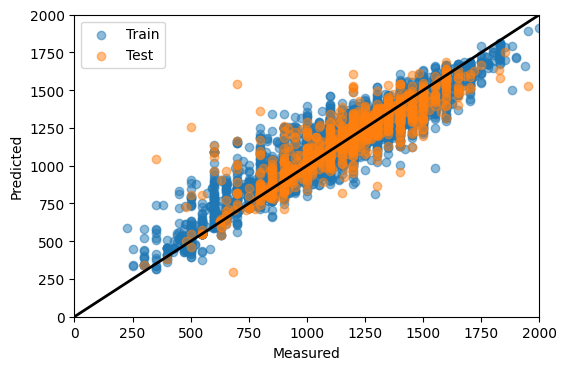

In [37]:
fig, ax = plt.subplots(dpi=100)
ax.scatter(y_train, y_pred_train, alpha=0.5, label="Train")
ax.scatter(y_test, y_pred, alpha=0.5, label="Test")
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
ax.legend()
ax.plot([0, 2000], [0, 2000], "k-", lw=2)
ax.set_xlim([0, 2000])
ax.set_ylim([0, 2000])
plt.show()

In [38]:
print("Fit Statistics:")

print("Training Score: {}".format(regr.score(X_train, y_train)))
print("Training MAE: {}".format(train_mae))
print("Training RMSE: {}".format(train_rmse))
print("Testing Score: {}".format(regr.score(X_test, y_test)))
print("Testing MAE: {}".format(test_mae))
print("Testing RMSE: {}".format(test_rmse))

Fit Statistics:
Training Score: 0.8941630526793054
Training MAE: 58.07166802966599
Training RMSE: 83.09635740063534
Testing Score: 0.7998221035868083
Testing MAE: 70.78695842411841
Testing RMSE: 109.48325531094342


In [22]:
inds = np.argsort(regr_importances)

In [23]:
for i in inds[::-1]:
    print(feature_labels[i], regr_importances[i])

Bi 0.10721381
Mo 0.054886356
P 0.05202782
W 0.0383391
Li 0.03643215
Cu 0.036362324
Al 0.034289885
N 0.030899748
B 0.030797807
Co 0.029559828
Se 0.02612158
O 0.026082106
Ce 0.024633104
V 0.023998227
Pb 0.02197637
C 0.021345882
Na 0.016832566
Te 0.016368724
La 0.016256157
U 0.013598499
Zr 0.012428634
Y 0.01241034
Sb 0.012013234
Rb 0.011744159
Th 0.011671901
Sr 0.011057983
Yb 0.010877325
Ag 0.01087246
Ti 0.010820303
Ba 0.01075997
Si 0.010437858
Cl 0.01020166
Ni 0.009729678
K 0.009229164
Lu 0.008950953
Hf 0.008811584
Ta 0.008566422
In 0.0076063755
Nd 0.007250904
Ga 0.0070978445
Sn 0.006950962
S 0.0069312723
Er 0.006771359
Nb 0.0067060506
Gd 0.006551846
Mn 0.006228595
Cd 0.006100064
Zn 0.0056600296
Fe 0.005529462
Tb 0.005481032
F 0.005417262
Ca 0.00524309
Cr 0.0050336896
Mg 0.0047821323
Cs 0.0047767716
Ge 0.004640612
Eu 0.0046133758
Sc 0.0041528316
Os 0.0041085226
Ho 0.00394374
Ir 0.0039353548
Dy 0.003885839
Sm 0.0037302936
Ru 0.0031058558
Pr 0.003062031
Tm 0.0025229654
Rh 0.0020339638
Pt 0

# SHAP explanations

In [24]:
explainer = shap.TreeExplainer(regr)

In [25]:
shap_values = explainer.shap_values(X_train)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


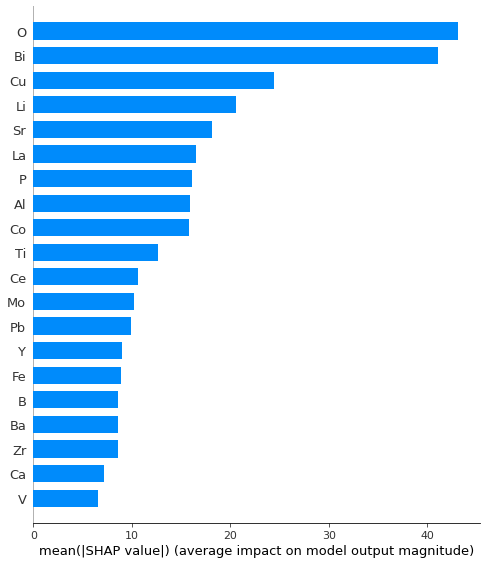

In [26]:
shap.summary_plot(shap_values, X_train, plot_type="bar", feature_names=feature_labels)

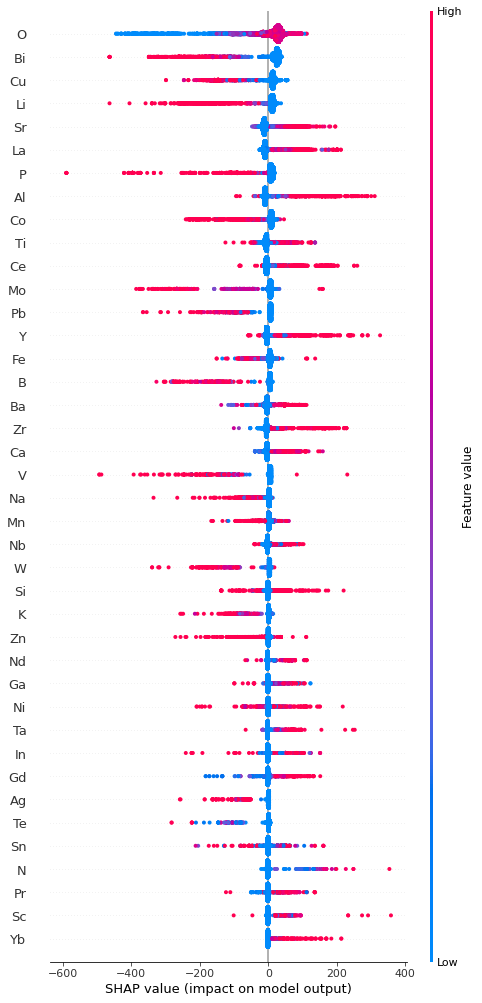

In [27]:
shap.summary_plot(shap_values, X_train, feature_names=feature_labels, max_display=40)

In [31]:
shap_values_test = explainer.shap_values(X_test)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


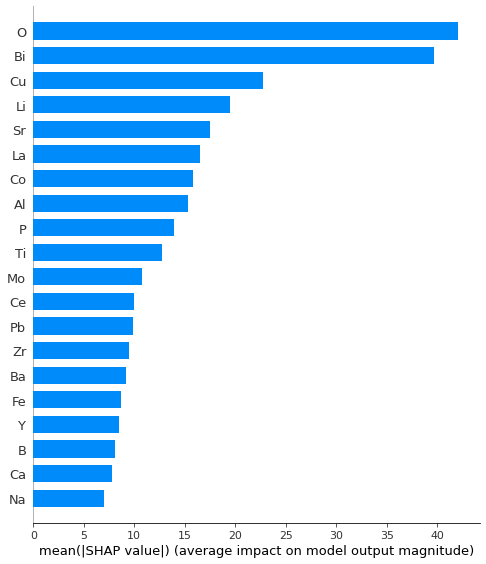

In [48]:
fig, ax = plt.subplots()
shap.summary_plot(shap_values_test, X_test, plot_type="bar", feature_names=feature_labels, max_display=20)
fig.tight_layout()
fig.savefig('figures/sinter_shap_bar.png', dpi=150)

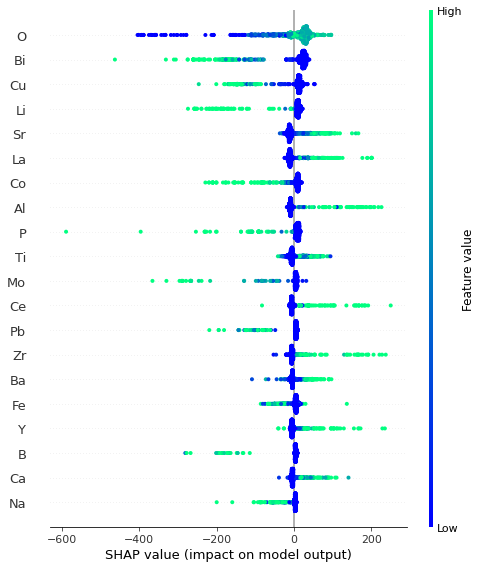

In [47]:
fig, ax = plt.subplots()
shap.summary_plot(shap_values_test, X_test, feature_names=feature_labels, max_display=20, cmap="winter")
fig.tight_layout()
fig.savefig('figures/sinter_shap.png', dpi=150)

# Check error as function of num. points

In [34]:
all_maes = []
all_rmses = []
all_r2 = []
min_num_pts = [i for i in range(1, 6)]
for i in min_num_pts:
    X_test_subset = []
    y_test_subset = []
    for ind in range(len(num_pts_test)):
        if num_pts_test[ind] >= i:
            X_test_subset.append(X_test[ind])
            y_test_subset.append(y_test[ind])
    y_pred_subset = regr.predict(X_test_subset)
    all_maes.append(mean_absolute_error(y_test_subset, y_pred_subset))
    all_rmses.append(mean_squared_error(y_test_subset, y_pred_subset, squared=False))
    all_r2.append(r2_score(y_test_subset, y_pred_subset))
    

In [35]:
pd.Series(num_pts_test).value_counts()

1     952
2     145
3      27
4      17
5       6
6       5
9       3
15      2
11      2
8       2
7       2
22      1
18      1
16      1
12      1
10      1
dtype: int64

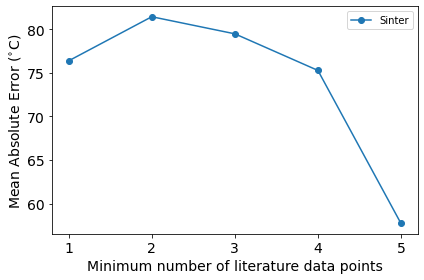

In [36]:
fig, ax = plt.subplots()
# plt.plot(num_pts, maes_2, marker='o')
plt.plot(min_num_pts, all_maes, marker='o')
ax.set_xlabel("Minimum number of literature data points", fontsize=14)
ax.set_ylabel("Mean Absolute Error ($^{\circ}$C)", fontsize=14)
ax.set_xticks(min_num_pts)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
# ax.legend(["Calcine", "Sinter"])
ax.legend(["Sinter"])
fig.tight_layout()
# fig.savefig("/home/jupyter/CJK/CVAE/ceder_imputed/all_targets/neurips_paper/figures/ss_mae_num_examples.png", dpi=200)

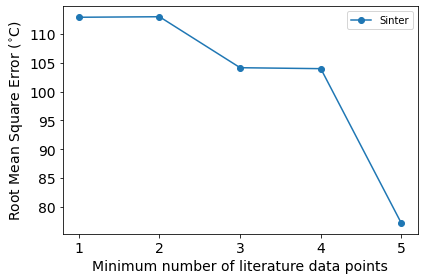

In [37]:
fig, ax = plt.subplots()
# plt.plot(num_pts, maes_2, marker='o')
plt.plot(min_num_pts, all_rmses, marker='o')
ax.set_xlabel("Minimum number of literature data points", fontsize=14)
ax.set_ylabel("Root Mean Square Error ($^{\circ}$C)", fontsize=14)
ax.set_xticks(min_num_pts)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
# ax.legend(["Calcine", "Sinter"])
ax.legend(["Sinter"])
fig.tight_layout()
# fig.savefig("/home/jupyter/CJK/CVAE/ceder_imputed/all_targets/neurips_paper/figures/ss_mae_num_examples.png", dpi=200)

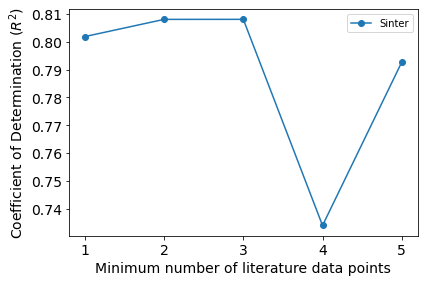

In [38]:
fig, ax = plt.subplots()
# plt.plot(num_pts, r2s_2, marker='o')
plt.plot(min_num_pts, all_r2, marker='o')
ax.set_xlabel("Minimum number of literature data points", fontsize=14)
ax.set_ylabel("Coefficient of Determination ($R^{2}$)", fontsize=14)
ax.set_xticks(min_num_pts)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
# ax.legend(["Calcine", "Sinter"])
ax.legend(["Sinter"])
fig.tight_layout()
# fig.savefig("/home/jupyter/CJK/CVAE/ceder_imputed/all_targets/neurips_paper/figures/ss_r2_num_examples.png", dpi=200)

1168


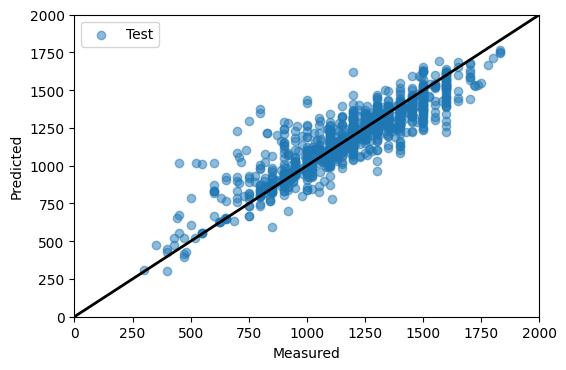

In [41]:
fig, ax = plt.subplots(dpi=100)
idx = [x for x in range(len(num_pts_test)) if num_pts_test[x] >= 1]
print(len(idx))
to_plot_test, to_plot_pred = [], []
for i in idx:
    to_plot_test.append(y_test[i])
    to_plot_pred.append(y_pred[i])
ax.scatter(to_plot_test, to_plot_pred, alpha=0.5, label="Test")
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
ax.legend()
ax.plot([0, 2000], [0, 2000], "k-", lw=2)
ax.set_xlim([0, 2000])
ax.set_ylim([0, 2000])
plt.show()